# Contents <a class="anchor" id="topofthepage">

0. [Introduction](#0)
1. [Spurious Regression](#1)  
  1.1. [Ways to identify spurious regression](#1.2)  
  1.2. [Theory behind spurious regression](#1.3)  
  1.3. [A solution for spurious regression: differencing](#1.4)  
  1.4. [Regression in the case of dependent variables](#1.5)    
2. [Cointegration](#2)  
  2.1. [Single cointegrating relationships](#2.0.1)  
  2.2. [Multiple cointegrating relationships](#2.0.2)  
  2.3. [Finding the number of cointegrating relationships](#2.0.3)  
  2.4. [Cointegration and Error Correction Models](#2.0.4)  
  2.5. [Fitting a bivariate ECM](#2.0.5)
3. [Example using Stock Data](#4)
4. [Appendix](#appendix)
5. [Additional reading material](#refs)

# Introduction <a class="anchor" id="0">

This article hopes to explain the concepts of cointegration and spurious regression. When possible, these concepts are explained without giving the exact mathematical formulation. However, in the case of cointegration one can not get away without showing some more in-depth maths. For the more mathematically inclined readers there is a list of references used while writing this article. In order to obtain the most out of it the reader should be familiar with linear regression and ARIMA models.

Overview of what you can expect in this article:
* First the concept of spurious regression is explored by means of an example.
* The theoretical results on spurious regression are discussed.
* Cointegration gets introduced as a way to cope with the spurious regression problems






[_Back to top_](#topofthepage)

# 1. Spurious Regression <a class="anchor" id="1">

Within time series analysis an often encountered phenomenon is spurious regression. 
A spurious regression can erroneously suggest a strong relationship between independent variables due to misleadingly high performance measurements. For example: the high correlation between the number of ordained ministers and the rate of alcoholism in Britain in the nineteenth century, or the price level and cumulative rainfall in the United Kingdom ([Phillips, 1998](http://dido.econ.yale.edu/korora/phillips/pubs/art/a128.pdf)). 

A spurious regression can occur when a linear regression model is applied while the assumption of independent, identically distributed error terms is violated. A common characteristic for time series data is the presence of correlation amongst the error terms. If the sample size is large enough the regression coefficients will appear to be statistically significant and thus an unsound (spurious) relation might be inferred. 

As an example: suppose we have the following two auto-regressive models:

$$ Y_t = \alpha Y_{t-1} +\varepsilon_t$$  
$$ X_t = \beta X_{t-1} +\omega_t$$  
where $\epsilon_t$, $\omega_t$ are independent, identically distributed standard normal random variables and $\alpha$, $\beta \in \mathbb{R}$ such that $\alpha$, $\beta \neq 0$. 

In time series literature these models are more commonly knows as AR(1) models (auto-regressive of order 1). 

If $\alpha$, $\beta =1$, then one can rewrite these equations as $Y_t = \sum_{i = 1}^t \varepsilon_i$ and $X_t = \sum_{i = 1}^t \omega_i$. These models are called random walks. Recall that when $|\alpha|$, $|\beta| \geq 1$, the series is non-stationary, otherwise it is stationary <sup>[1](#stationary)</sup>.  
We investigate the concept of spurious regression in this context.


In [1]:
# Simulate two independent, non-stationary AR(1) models 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.stats.stattools import durbin_watson


n = 2000 # Size of the training set
m = 1000 # Size of test set 
a = b = 1

np.random.seed(99) # One can try different seeds.

e = np.random.normal(size = n + m)
w = np.random.normal(size = n + m)


index = pd.date_range(start = "2013-01-01", periods = n + m)


x_total = np.zeros(n + m)
y_total = np.zeros(n + m) 
for t in range(n + m):
    x_total[t] = a*x_total[t-1] + e[t] # Important observation: x does not depend on y and vice versa.
    y_total[t] = b*y_total[t-1] + w[t]

x = pd.Series(x_total[:n], index = index[:n])
y = pd.Series(y_total[:n], index = index[:n])

x_future = pd.Series(x_total[n:], index = index[n:])
y_future = pd.Series(y_total[n:], index = index[n:])



/datadrive/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


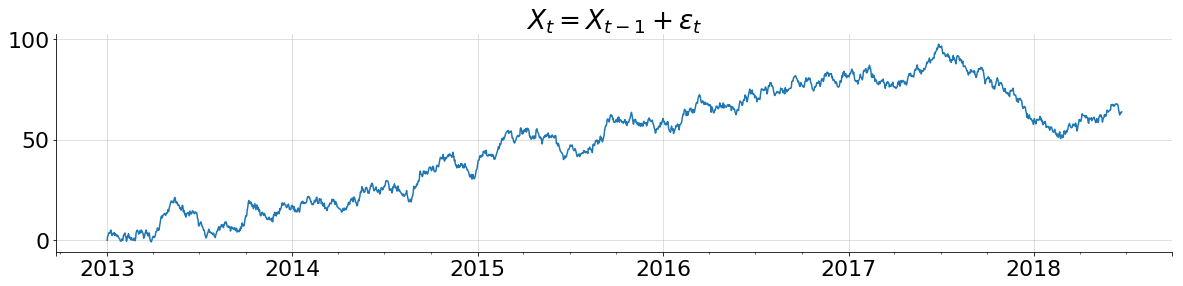

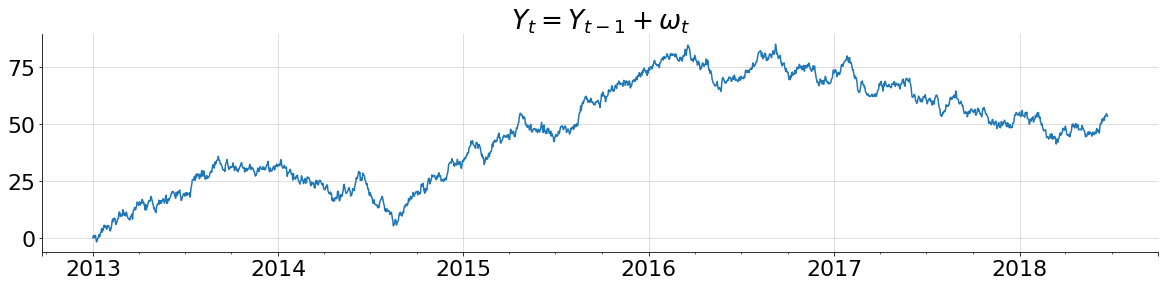

In [2]:
# Plot the two time series

matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize = (20,4))
x.plot()
ax = plt.gca()
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'$X_{t} = X_{t-1} + \varepsilon_t$')
plt.figure(figsize = (20,4))
plt.title('$Y_{t} = Y_{t-1} + \omega_{t}$')
y.plot()
ax = plt.gca()
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The above two time series have a similar trend. For now let us assume you have been given this data with no additional information about the data and your employer asks you to predict $Y$. Unbeknownst of the independence between the two time series, one proceeds to make a scatter plot.

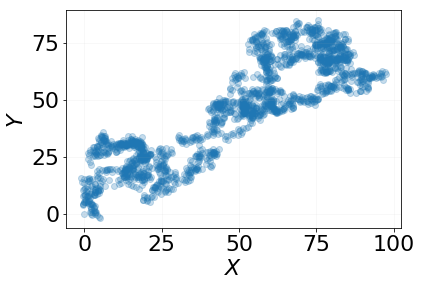

In [3]:
plt.figure()
plt.scatter(x, y, alpha = 0.25)
plt.xlabel('$X$')
plt.ylabel('$Y$')
ax = plt.gca()
ax.grid(b = True, alpha = 0.1);

The scatter plot might suggests the possibility of a linear relationship between $X$ and $Y$. A possible follow-up step would be to use least squares regression to investigate this apparent relation.

In [4]:
model = sm.OLS(y, sm.add_constant(x)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     6027.
Date:                Thu, 17 May 2018   Prob (F-statistic):               0.00
Time:                        08:45:57   Log-Likelihood:                -7638.6
No. Observations:                2000   AIC:                         1.528e+04
Df Residuals:                    1998   BIC:                         1.529e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8966      0.509     23.379      0.0

The obtained model can be written as $Y_t = 0.7104X_t + 11.8966$ with a significant $t$-value of 77.635 for the estimate $\hat{\beta}_1 = 0.7104$.  

The $R^2$ statistic does not give a strong indication for distrusting the model (I've tried different seeds to obtain a particularly high $R^2$ for the purpose of this document). One could therefore conclude that one unit change in $X$ results in an increase of 0.7104 in $Y$.  

The catch is that the $X$ and $Y$ are generated independently and as such the above conclusion cannot be true. The true value of $\beta_1$ should be 0.  

In the next code block we show what happens if one uses the model for forecasting. Recall that we've made a test set `x_future` and `y_future` for this purpose. 

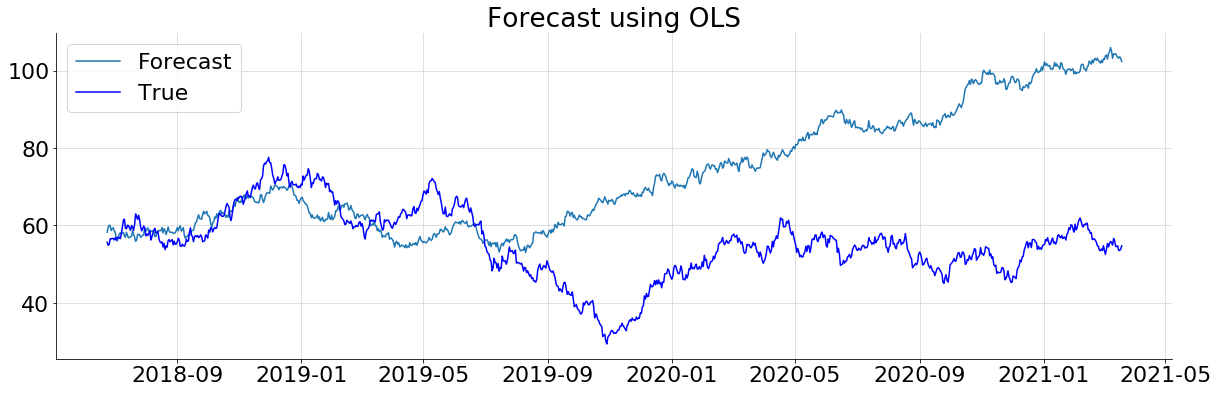

In [5]:
# TO DO ADD BENCHMARK.
y_pred = model.predict(sm.add_constant(x_future))

fig, ax = plt.subplots(figsize = (20,6))
ax.plot(y_pred, '-', label="Forecast")
ax.plot(y_future, 'b-', label="True")
ax.legend(loc="best")
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Forecast using OLS");

Due to the independency of $X$ and $Y$ anything could have happened. In fact, the forecast is itself an AR(1) process <sup>[2](#linearAR)</sup>. 

[_Back to top_](#topofthepage)

## Ways to identify spurious regression <a class="anchor" id="1.2">

Ordinary least squares makes the assumption that the error terms are independent, identically distributed normal random variables with mean 0 and standard deviation $\sigma$. In the example above the assumption that the error terms are independent is violated! In this case the residuals are auto-correlated. What does this mean? In this case, the fact that $\varepsilon_i$ is positive provides information about the sign of $\varepsilon_{i+1}$. 

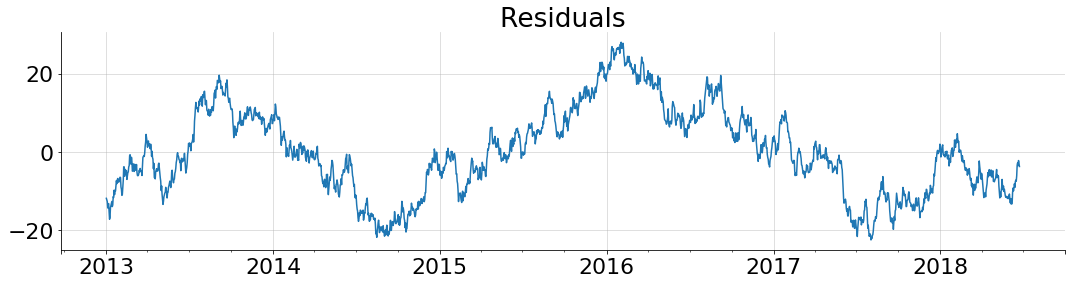

In [6]:
# Plot the residuals

plt.figure(figsize = (18,4))
model.resid.plot()
ax = plt.gca()
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Residuals");


The residual plot is clearly not white noise. One can even deduce that the previous error might be indicative of the next error. The residuals are an $I(1)$ time series. Recall that $I(1)$ means that the time series is integrated of order 1: the minimum number of differences required to obtain an stationary time series is 1.

The augmented Dickey-Fuller test and the KPSS test are usually used in combination to test if a time series is $I(1)$. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. The KPSS test can be used to test if the data is stationary.

In [7]:
adf = adfuller(model.resid, regression = "ct", maxlag = 1)
kpss = sm.tsa.kpss(model.resid, regression = "ct")
print("Augmented Dickey-Fuller p-value: {:.2f}".format(adf[1]))
print("KPSS p-value: {:.2f}".format(kpss[1]))

Augmented Dickey-Fuller p-value: 0.25
KPSS p-value: 0.01


/datadrive/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Both tests give us reasons to believe the residuals are non-stationary.  
Another test which fits this example perfectly is the the Durbin-Watson test. The Durbin-Watson (DW) test statistic detects the the presence of autocorrelation of lag 1 for the prediction errors. The Durbin-Watson test statistic is 
$$ d = \frac{\sum\limits_{t=2}^{T}(\varepsilon_t - \varepsilon_{t-1})^2}{\sum\limits_{t=1}^T\varepsilon_t^2}$$
where $\varepsilon_t$ are the residuals. 

This can be interpreted as follows:  

if the consecutive residuals are close, then the test statistic tends to be small. The rule-of-thumb is that a Durbin-Watson test statistic near 0 indicates there is autocorrelation. The `model.summary()` output above already included this statistic. The DW statistic for this regression model is 0.013, a serious indication of the presence of auto-correlation of lag 1. In the case of no auto-correlation one would expect a DW statistic of around 2.

The main drawback of the Durbin-Watson statistic is that it only checks for auto-correlation at lag 1. It should not come as a surprise that people have come up with versions of the DW statistic that check for higher order lags. Another test is the Breusch–Godfrey test. Under the null hypothesis the BG test has no autocorrelation in the residuals up to a specific lag $k$. 


In [8]:
import statsmodels.stats.diagnostic as dg

BG = dg.acorr_breusch_godfrey(model, nlags = 5)

print("Breusch-Godfrey p-value: {:.2f}".format(BG[1]))


Breusch-Godfrey p-value: 0.00


The null gets rejected and thus we conclude that there is some auto-correlation in at least one lag lower than 6. 

[_Back to top_](#topofthepage)

## Theory behind spurious regression <a class="anchor" id="1.3">

In this section a short overview of the statistical theory behind spurious regression is given. These results are proven in [Phillips, 1998](http://dido.econ.yale.edu/korora/phillips/pubs/art/a128.pdf).  
Assume the model:

$$ Y_t =  Y_{t-1} +\varepsilon_t$$  
$$ X_t = X_{t-1} +\omega_t$$  
where $\varepsilon_t$, $\omega_t$ are independent, identically distrubuted standard normal random variables and $X_0 = Y_0 =0$.  
Consider estimating the parameters of the following model using least squares and with data originating from the model above:   

$$Y_t = \beta_0 + \beta_1 X_t  + \eta_t$$

Then:
* $\hat{\beta}_1$ converges in distribution to a non-normal random variable with a mean not necessarily equal to 0.
* The $t$-statistic for $\hat{\beta}_1$ converges to $\pm \infty $ as the sample size goes to infinity.
* $R^2$ converges to 1 as the sample size goes to infinity.
* The Durbin-Watson test statistic converges to 0 as the sample size goes to infinity.


The first three bullet points explain the concept of spurious regression. 
*  $\hat{\beta}_1$ incorrectly suggests a relation exists (i.e. $\hat{\beta}_1$ does not necessarily converge to its true value of 0).  
*  The incorrect estimate for $\beta_1$ appears to be statistically significant.
*  The model appears to fit the data well. 

And this, while $X$ and $Y$ are independent. A severe consequence for not validating the assumptions of your model!
 


[_Back to top_](#topofthepage)

## A solution for spurious regression: differencing <a class="anchor" id="1.4">

The example above shows that regressing two independent $I(1)$ time series might give spurious results. However, what if we have two $I(1)$ time series that do have some relation with each other?  

The mathematical answer is to simply take first differences ($Y_t - Y_{t-1}$) to obtain stationary time series. The conclusions obtained from least squares are then statistically valid. The downside is that if the time series are cointegrated, then differencing loses information in the long run. By differencing one removes the stochastic trend of the data. 

In the code block below we run the regression on the differenced series and obtain the expected results (there is no linear relationship between Y and X). 

In [9]:
# Regression on first differences

delta_x = diff(x)
delta_y = diff(y)
model = sm.OLS(delta_y, delta_x).fit()
print(model.summary())
BG = dg.acorr_breusch_godfrey(model, nlags = 5)
print("Breusch-Godfrey p-value: {:.2f}".format(BG[1]))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.100
Date:                Thu, 17 May 2018   Prob (F-statistic):              0.294
Time:                        08:45:58   Log-Likelihood:                -2880.9
No. Observations:                1999   AIC:                             5764.
Df Residuals:                    1998   BIC:                             5769.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0237      0.023      1.049      0.2

As stated earlier, one should check the residuals for any interesting pattern and see if the Durbin-Watson statistic is around 2. The DW statistic for this model looks normal. We've also printed out the p-value for the Breusch-Godfrey test. The tests give no indication for distrusting the model, which is a very poor fit, suggesting there is no relation.

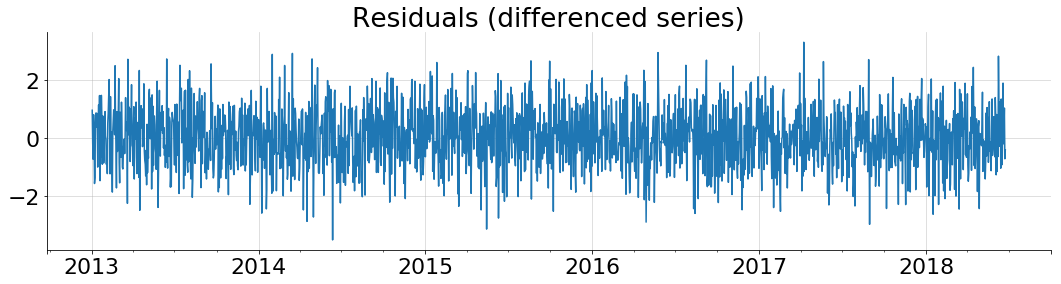

In [10]:
# Plot the residuals

plt.figure(figsize = (18,4))
model.resid.plot()
ax = plt.gca()
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Residuals (differenced series)");

A visual inspection of the residuals gives us no reason for believing that the residuals are not white noise.

In [11]:
adf = adfuller(model.resid, maxlag = 1)
print("Augmented Dickey-Fuller p-value: {:.2f}".format(adf[1]))

Augmented Dickey-Fuller p-value: 0.00


The test fails and thereby validates the model's assumptions of i.i.d. errors. In this case the model is correctly applied, however the predictive power of the model is low to nonexistent (as shown by the abysmal $R^2$).

[_Back to top_](#topofthepage)

## Regression in the case of dependent variables <a class="anchor" id="1.5">
In the previous paragraph we've seen how to identify spurious regression for independent, non-stationary time series (AR(1)), shown some mathematical properties and illustrated how to correctly apply ordinary least squares.  
One might wonder how this all relates to dependent, non-stationary time series. What if a linear relation does exist? We will give the following example. Consider the following model:

$$ Y_t = \alpha X_{t} + \varepsilon_t$$  
$$ X_t = \beta X_{t-1} + \omega_t$$

where $\epsilon_t$, $\omega_t$ are $I(0)$ time series (e.g. white noise) and $\alpha$, $\beta \in \mathbb{R}$ such that $\alpha$, $\beta \neq 0$. Note that, as opposed to the earlier examples, the errors may be $I(0)$.

When $|\alpha| \geq 1$, $X_t$ is a non-stationary AR(1) process and hence so is $Y_t$. In this case there is a linear relationship between $X$ and $Y$ and one would hope that we could apply least squares to find the linear relation $Y_t = \beta_0 + \beta_1 X_t +\varepsilon_t$. To be more precise, consider the following approach: 

* Estimate $\beta_0$, $\beta_1$ by means of OLS.
* Verify that the residuals do not have a unit root by means of an augmented Dickey-Fuller test.
* Visually inspect the residuals for any patterns.
* Inspect the Durbin-Watson statistic and the p-values of the Breusch-Godfrey test.

However, as we shall see in the example below, the residuals might still be auto-correlated. Because the $\varepsilon_t$ in the model specified above are $I(0)$, it is possible it is an AR(1) process. This makes it impossible to distinguish if the regression is spurious or not. 

Engle and Granger (1987) developed a test to check whether there exists such a relationship between the two time series (called a _cointegrating_ relation), which is now commonly referred to as the Engle-Granger two step approach. The test is implemented in python as `statsmodels.tsa.stattools.coint`. More information about the trend parameter can be found in [MacKinnon (2010)](http://ideas.repec.org/p/qed/wpaper/1227.html).

Below we illustrate the above with an example. The model is:

$$ 
\begin{equation}
X_t = X_{t-1} + \omega_t 
\tag{1} 
\label{one}
\end{equation}
$$  
$$ Y_t = 0.6 X_{t-2} + \varepsilon_t$$

where $\omega_t, \varepsilon_t$ are stationary AR(1) processes.

In [12]:
# Create two cointegrated time series 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.stats.stattools import durbin_watson

n = 300 # Size of the training set
m = 50 # Size of test set 
a1 = 0.75 #0.75
a2 = 0.42
b = 0.6 #0.6
sigma = 0.5
np.random.seed(1) # One can try different seeds.

e1 = np.random.normal(scale = sigma, size = n + m)
e2 = np.random.normal(scale = sigma, size = n + m)


index = pd.date_range(start = "2013-01-01", periods = n + m)


x_total = np.zeros(n + m)
y_total = np.zeros(n + m) 
u1 = np.zeros(n + m)
u2 = np.zeros(n + m)

for t in range(n + m):
    u1[t] = a1 * u1[t-1] + e1[t] # stationary AR(1) errors.
    u2[t] = a2 * u2[t-1] + e2[t]

for t in range(n + m):
    x_total[t] = x_total[t-1] + u2[t] 
    y_total[t] = b * x_total[t-2] + u1[t] # Important observation: y does depend on x. 
    
x = pd.Series(x_total[:n], index = index[:n])
y = pd.Series(y_total[:n], index = index[:n])

x_future = pd.Series(x_total[n:], index = index[n:])
y_future = pd.Series(y_total[n:], index = index[n:])

In [13]:
# Plot the two time series

fig, ax = plt.subplots(figsize = (20,6))
ax.plot(x, '-', label=r'$X_t = X_{t-1} + \omega_t$')
ax.plot(y, 'b-', label=r"$ Y_t = 0.6X_{t-2} + \varepsilon_t$")
ax.legend(loc="best")
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Two Cointegrated Time Series");

In [14]:
# Test for cointegration

from statsmodels.tsa.stattools import coint

# Test for no-cointegration of a univariate equation.
# The null hypothesis is no cointegration. Variables in x and y are
# assumed to be integrated of order 1, I(1).

coin = coint(x,y) 
print("p-value:{:.2f}".format(coin[1]))

p-value:0.02


In [15]:
# Fit the model

model = sm.OLS(y, sm.add_constant(x)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     3493.
Date:                Thu, 17 May 2018   Prob (F-statistic):          1.28e-166
Time:                        08:45:59   Log-Likelihood:                -392.74
No. Observations:                 300   AIC:                             789.5
Df Residuals:                     298   BIC:                             796.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.078      2.089      0.0

Note that OLS gives us an estimate of 0.62 for the true value of 0.6.  

Stock (1987) and Phillips (1991) showed that 

* The least squares estimate $\hat{\beta}_1$ is consistent for $\beta_1$.
* The aymptotic variance for $\hat{\beta}_1$ calculated by OLS is incorrect.
* Even though the asymptotic bias, $\mathbb{E}(\mid \hat{\beta}_1 - \beta_1 \mid$), goes to zero as the sample size gets large, $\hat{\beta}_1$ may be substantially biased in small sample sizes.

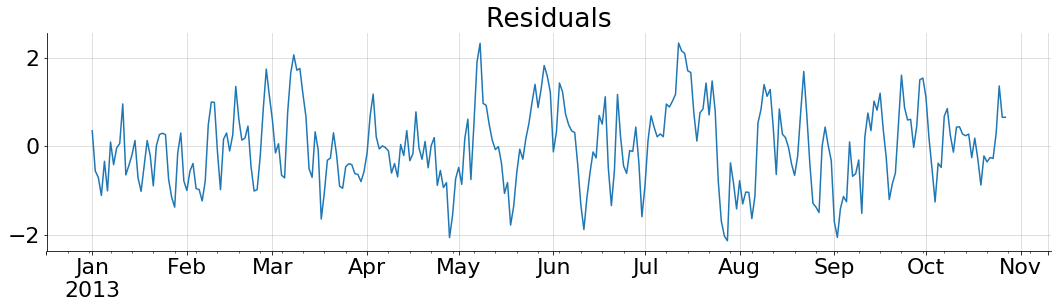

In [16]:
# Plot the residuals

plt.figure(figsize = (18,4))
model.resid.plot()
ax = plt.gca()
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Residuals");

[_Back to top_](#topofthepage)

# 2. Cointegration  <a class="anchor" id="2">

In this section we delve deeper into the concept of cointegration.

## Single cointegrating relationships <a class="anchor" id="2.0.1">
Two time series $X_t$, $Y_t$ are said to be cointegrated (of order 1) iff both are $I(1)$ and there exist a $\gamma \in \mathbb{R}$ such that $Y_t - \gamma X_t \sim  I(0)$.  
In order words; two time series are cointegrated if a linear combination of the two is stationary. 

The same definition can be generalized to more than two time series.  
Let $\textbf{Y}_\textbf{t}$ be an (n x 1)-vector containing $n$ $I(1)$ time series $Y_{1,t}, \dots, Y_{n,t}$. If there exists an (1 x n)-vector  $\beta = (\beta_1, \dots, \beta_n)$ such that  

$$ \beta \mathbf{Y}_\mathbf{t} = \beta_1 y_{1,t} + \beta_2 y_{2,t} + \cdots + \beta_n y_{n,t} \sim I(0)$$.

then $\mathbf{Y}_\mathbf{t}$ is _cointegrated_.
Note that in the case of cointegration the vector $\beta$ is not unique, e.g. $2\beta$ is also a cointegration vector. Therefore some form of normalization is useful. A typical normalization for $\beta$ is $(1,-\beta_2,\dots,-\beta_n)$. The cointegration relation may then be expressed as:      

$$ y_{1,t} = \beta_2 y_{2,t} + \cdots + \beta_n y_{n,t} + \varepsilon_t $$

with $\varepsilon_t \sim I(0)$.

## Multiple cointegrating relationships <a class="anchor" id="2.0.2">

For multiple time series it is possible that there exists more than one cointegrating relationship. Also, if two cointegrating vectors $\beta_1, \beta_2$ are found, then a linear combination $c_1\beta_1 + c_2\beta_2$ is also a cointegrating vector. This makes finding the cointegration vectors a lot more challenging.

## Finding the number of cointegrating relationships <a class="anchor" id="2.0.3">

Engle and Granger developed tests for testing cointegration in the case of at most one cointegrated vector. This was the same test as mentioned before. Johansen (1988) considered the case when there are possibly more than one cointegrating relationship. Johansens method is at the moment of writing (2018) the preferred way to find the cointegration vector. In this article we will focus on the Engle-Granger two-step approach. Mainly because it requires less knowledge of advanced mathematics and hence suits the purpose of this article better.  

## Cointegration and Error Correction Models <a class="anchor" id="2.0.4">

Consider the bivariate case of two cointegrated time series $\textbf{Y}_\textbf{t} = (Y_{1,t},Y_{2,t})$ with cointegrating vector $(1, -\beta_2)$. Engle and Granger showed that in this case there is a way for modelling the short term trends as well as the long term trends by means of an Error Correction Model (ECM).

$$ 
\begin{equation}
\Delta Y_{1,t} = c_1 +\alpha_1(Y_{1,t-1} -\beta_2 Y_{2,t-1}) + \sum\limits_{j=0}\limits^k \phi_{1,1}^j\Delta Y_{1,t-j} + \sum\limits_{j=0}\limits^{l} \phi^j_{1,2}\Delta Y_{2,t-j} + \varepsilon_{1,t}  \tag{2} \label{eq:two}
\end{equation}
$$

$$
\begin{equation}
\Delta Y_{2,t} = c_2 +\alpha_2(Y_{1,t-1} -\beta_2 Y_{2,t-1}) + \sum\limits_{j = 0}\limits^m \phi^j_{2,1}\Delta Y_{1,t-j} + \sum\limits_{j=0}\limits^{n}\phi^j_{2,2}\Delta Y_{2,t-j} + \varepsilon_{2,t} \tag{3} \label{eq:three}
\end{equation}
$$
 
where $\phi^j$ should be interpreted as the coefficient of the j-th lag. 

A daunting model at first, but quite logical nevertheless. A simplified, more verbose way of thinking about the model is:

$$
\begin{equation}
\Delta Y_{1,t} = \text{Intercept} + \text{long-term cointegrating relation} + \text{lagged terms of }\Delta Y_1 +\text{lagged terms of } \Delta Y_2 + \text{error} 
\tag{2'} \label{eq:twoprime}
\end{equation}
$$
$$
\begin{equation}
\Delta Y_{2,t} = \text{Intercept} + \text{long-term cointegrating relation} + \text{lagged terms of }\Delta Y_1 +\text{lagged terms of }\Delta Y_2 + \text{error}
\tag{3'} \label{eq:threeprime}
\end{equation}
$$

The crux of the model is that all the right-hand side terms are $I(0)$. By definition of cointegration, $Y_1, Y_2$ are $I(1)$, so $\Delta Y_1, \Delta Y_2$ are $I(0)$ and by the same definition $Y_{1,t-1} -\beta_2 Y_{2,t-1}$ is $I(0)$. This means the model can be fitted using least squares without any spurious regression occuring.   

The long-term relationship between the variables $Y_1$ and $Y_2$ is captured in the cointegration relation. Because this relation occurs in both (2) and (3) the two time series tend to 'move together'.  

The short-term relationship is modelled by the lagged terms. As there are only a finite number of lagged terms, at one point the impact of a significant shift in $Y_1$ or $Y_2$ does not get accounted for anymore.  

In most cases the cointegration vector $\beta$ is unknown, but can be consistently estimated by regressing $Y_1$ on $Y_2$ as noted earlier.

[_Back to top_](#topofthepage)

## Fitting a bivariate ECM <a class="anchor" id="2.0.5">

We consider fitting the above model (1) by means of an ECM. For demonstration purposes, we assume no prior knowledge about the data. By this we mean that we do not know how the data is generated and if it is cointegrated or not.

* Step 0: Test for $I(1)$  using ADF.
* Step 1: Test for cointegration
* Step 2: Estimate the cointegration vector $\beta$ by means of least squares  
As noted earlier, least squares gives a consistent estimator for the cointegration vector. This estimator is used for ECM.
* Step 3: Estimate the number of lags neccesary  
This can be done via either looking the AIC/BIC values of the model or by checking which coefficients are statistically significant. Another viable way is to use some form of regularization like LASSO or Ridge. See for example [Konzen and Ziegelmann](https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=SBE36&paper_id=128) for more details.
* Step 4: Fit the ECM by means of least squares.

In [17]:
# Step 1

# Test for no-cointegration of a univariate equation.
# The null hypothesis is no cointegration. Variables in x and y are
# assumed to be integrated of order 1, I(1).

from statsmodels.tsa.stattools import coint

coin = coint(x,y) 
print("p-value:{:.2f}".format(coin[1]))

p-value:0.02


In [18]:
# Step 2: Get the beta 

model = sm.OLS(y,x).fit()
beta2 = model.params[-1]
print(beta2)

0.6062694493025504


In [19]:
# Step 3: Estimate the number of lags

# In this case we estimate the number of lags to 3. Normally, one would include a higher number of lagged variables
# and select the only the significant ones.

In [20]:
# Step 4: Fit the ECM

# get the differenced data

diff1_y = diff(y)
diff1_x = diff(x)

# get estimated errors

coint_rel = y - beta2 * x

# adjust for data loss due to differencing and get the lags

coint_rel_lag1 = coint_rel[3:-1]
diff1_y_lag1 = diff1_y[2:-1]
diff1_x_lag1 = diff1_x[2:-1]
diff1_y_lag2 = diff1_y[1:-2]
diff1_x_lag2 = diff1_x[1:-2]
diff1_y_lag3 = diff1_y[:-3]
diff1_x_lag3 = diff1_x[:-3]

diff_y = diff1_y[3:]


# fit the model

X = np.column_stack((coint_rel_lag1, diff1_x_lag1, diff1_x_lag2, diff1_x_lag3, diff1_y_lag1, diff1_y_lag2, diff1_y_lag3))
model1 = sm.OLS(diff_y, sm.add_constant(X)).fit()



In [21]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     31.22
Date:                Thu, 17 May 2018   Prob (F-statistic):           4.70e-32
Time:                        08:45:59   Log-Likelihood:                -194.48
No. Observations:                 296   AIC:                             405.0
Df Residuals:                     288   BIC:                             434.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0377      0.028      1.340      0.1

We drop the non-significant estimators and fit the model again.


In [22]:
model2 = sm.OLS(diff_y, np.column_stack((coint_rel_lag1, diff1_x_lag1, diff1_x_lag2))).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     72.49
Date:                Thu, 17 May 2018   Prob (F-statistic):           4.27e-35
Time:                        08:45:59   Log-Likelihood:                -196.06
No. Observations:                 296   AIC:                             398.1
Df Residuals:                     293   BIC:                             409.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3168      0.043     -7.451      0.0

The fitted model has a moderate $R^2$. It is interesting to compare the ECM to other models. The standard model the ECM is trying to outperform is the first differenced auto-regressive model, e.g. a VAR in differences.

In [23]:
model3 = sm.OLS(diff_y, np.column_stack((diff1_x_lag2, diff1_x_lag3, diff1_y_lag1))).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     50.53
Date:                Thu, 17 May 2018   Prob (F-statistic):           2.38e-26
Time:                        08:45:59   Log-Likelihood:                -216.52
No. Observations:                 296   AIC:                             439.0
Df Residuals:                     293   BIC:                             450.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5846      0.057     10.203      0.0

The inclusion of the cointegration term increased the explanative power of the model. The $R^2$ has (additively) increased by about 10%. Since models are being compared, the AIC and BIC values can also be considered. Both the AIC and BIC are lower for the ECM. This indicates a clear preferences towards the ECM. 

[_Back to top_](#topofthepage)

# 3. Example <a class="anchor" id="4">

In this section an example is given using 'real' data. Our goal is to determine wheter there are any stocks cointegrated.

## Cointegration between stock prices 
In this section an example is given using 'real' data. Our goal is to determine wheter there are any stocks cointegrated.
Cointegrated stocks are the basis for algorithmic trading strategy called _pairs trading_. In this section we will investigate if there are any cointegrated stock prices.

In [24]:
# Load the stock data
# get the datareader via !pip install pandas-datareader


from pandas_datareader import data as web
from datetime import datetime

start = datetime(2013, 1, 1)
end = datetime(2015, 12, 31)

apple_unsorted = web.DataReader('WIKI/AAPL', 'quandl', start, end)
google_unsorted = web.DataReader('WIKI/GOOGL', 'quandl', start, end)
microsoft_unsorted = web.DataReader('WIKI/MSFT', 'quandl', start, end)
fb_unsorted = web.DataReader('WIKI/FB', 'quandl', start, end)
amazon_unsorted = web.DataReader('WIKI/AMZN', 'quandl', start, end)
ebay_unsorted = web.DataReader('WIKI/EBAY', 'quandl', start, end)
ibm_unsorted = web.DataReader('WIKI/IBM', 'quandl', start, end)



In [25]:
# some preprocessing

apple = apple_unsorted.sort_index()
google = google_unsorted.sort_index()
microsoft = microsoft_unsorted.sort_index()
fb = fb_unsorted.sort_index()
amazon = amazon_unsorted.sort_index()
ebay = ebay_unsorted.sort_index()
ibm = ibm_unsorted.sort_index()

apple_close = apple.loc[:,"Close"]
google_close = google.loc[:,"Close"]
microsoft_close = microsoft.loc[:,"Close"]
fb_close = fb.loc[:,"Close"]
ebay_close = ebay.loc[:,"Close"]
ibm_close = ibm.loc[:,"Close"]
amazon_close = amazon.loc[:,"Close"]


In [26]:
# Step 0: Check for non-stationarity

dic = {"apple_close" : apple_close, 
      "google_close" : google_close,
      "microsoft_close" : microsoft_close,
      "fb_close" : fb_close,
      "ebay_close" : ebay_close, 
      "ibm_close" : ibm_close,
      "amazon_close" : amazon_close}

for stock in dic.keys():
    print(stock, adfuller(dic[stock])[1])


apple_close 0.4858713590133332
google_close 0.4928196694082135
microsoft_close 0.7562159185825926
fb_close 0.9172017511916958
ebay_close 0.5191866901203075
ibm_close 0.7773357519627397
amazon_close 0.9973735352159561


In [29]:
# Step 1: Check for cointegration amongst the different stocks

from itertools import combinations

pairs = list(combinations(dic.keys(), 2))

# we check for cointegration in the log of stock prices
for pair in pairs:
    print("The p-value for " + pair[0] + " and " + pair[1] +  " is: {:.2f}".format(coint(np.log(dic[pair[0]]), np.log(dic[pair[1]]))[1]))


The p-value for apple_close and google_close is: 0.14
The p-value for apple_close and microsoft_close is: 0.24
The p-value for apple_close and fb_close is: 0.51
The p-value for apple_close and ebay_close is: 0.75
The p-value for apple_close and ibm_close is: 0.57
The p-value for apple_close and amazon_close is: 0.77
The p-value for google_close and microsoft_close is: 0.38
The p-value for google_close and fb_close is: 0.42
The p-value for google_close and ebay_close is: 0.63
The p-value for google_close and ibm_close is: 0.59
The p-value for google_close and amazon_close is: 0.61
The p-value for microsoft_close and fb_close is: 0.03
The p-value for microsoft_close and ebay_close is: 0.50
The p-value for microsoft_close and ibm_close is: 0.17
The p-value for microsoft_close and amazon_close is: 0.46
The p-value for fb_close and ebay_close is: 0.76
The p-value for fb_close and ibm_close is: 0.62
The p-value for fb_close and amazon_close is: 0.79
The p-value for ebay_close and ibm_close i

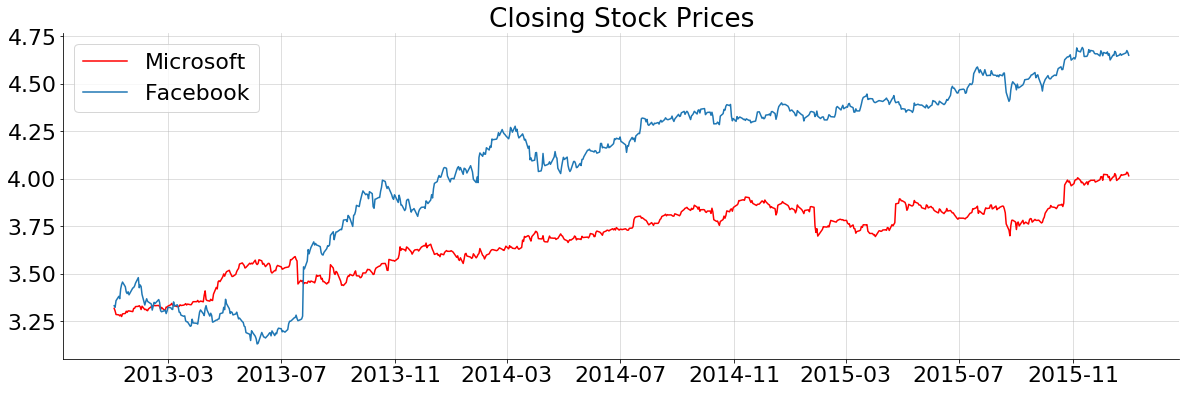

In [30]:
# Plot the cointegrated stock prices

fig, ax = plt.subplots(figsize = (20,6))
#ax.plot(google_close, '-', label="Google")
#ax.plot(apple_close, 'b-', label="Apple")
ax.plot(np.log(microsoft_close), 'r-', label="Microsoft")
ax.plot(np.log(fb_close), label="Facebook")
#ax.plot(amazon_close, label="Amazon")
#ax.plot(ibm_close, label="IBM")

ax.legend(loc="best")
ax.grid(b = True, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Closing Stock Prices");

# 4. Appendix <a class="anchor" id="appendix">

## 1. Stationarity <a class="anchor" id="stationary">

A series $X_t$ is (weakly or covariance) stationary iff
* $ \mathbb{E}(X_t) = \mathbb{E}(X_{t-h})$ for all $h$.
* $\text{Var}(X_t) = \text{Var}(X_{t-h})$ for all $h$.
* $\text{Cov}(X_t, X_{t-h}) = \text{Cov}(X_{t+j},X_{t+j-h})$ for all $j$.

## 2. Linear transformation of AR(1) <a class="anchor" id="linearAR">

In this section we show that the forecasted values is indeed an AR(1) process by means of a simple derivation.

$$\begin{aligned} \hat{Y}_t & = 0.7104X_t + 11.8966 \\ 
 & = 0.7104 (X_{t-1} + \varepsilon_{t-1}) +  11.8966 \\
 & = 0.7104 X_{t-1} + 11.8966 + 0.7104 \varepsilon_{t-1} \\
 & = \hat{Y}_{t-1} + 0.7104\varepsilon_{t-1}
 \end{aligned}$$
 
 where $0.7104\varepsilon_{t-1} \sim \mathcal{N}(0, 0.7104^2 \sigma^2)$

# Additional reading material <a class="anchor" id="refs">

[Eric Zivot and Jiahui Wang (2003), Cointegration, in _Modeling Financial Time Series with S-PLUS_ (p429-478)](http://faculty.washington.edu/ezivot/econ584/notes/cointegration.pdf)

[Susmel, Rauli (2015). Lecture 18: cointegration](https://www.bauer.uh.edu/rsusmel/phd/ec2-7.pdf)

[Li, Jing (2016). Lecture 8a: cointegration](http://www.fsb.miamioh.edu/lij14/672_2014_s8.pdf)

[Cochrane, John H. (2018), A Brief Parable of Over-Differencing](http://faculty.chicagobooth.edu/john.cochrane/research/papers/overdifferencing.pdf)

[Sheppard, K. (2017), Chapter 5 (Multivariate Time Series), in Financial Econometrics Syllabus](https://www.kevinsheppard.com/images/5/56/Chapter5.pdf)

[Engle, Robert and Granger, Clive, (1987), Co-integration and Error Correction: Representation, Estimation, and Testing, Econometrica, 55, issue 2, p. 251-76,](http://www.ntuzov.com/Nik_Site/Niks_files/Research/papers/stat_arb/EG_1987.pdf)

[Stock, James H. (1987), Asymptotic properties of least squares estimators of cointrigrating vectors, Econometrica, Vol. 55, No. 5, 1035-1056, DOI: 10.2307/1911260](https://pdfs.semanticscholar.org/5f84/f361cb4f2f68538dfb9ecd97c46710f0be47.pdf)

[Phillips, Peter C.B. (1998), New tools for Understanding Spurious Regressions, Econometrica: NOV 1998, VOLUME 66, ISSUE 6, DOI: 0012-9682(199811)66:6<1299:NTFUSR>2.0.CO;2-4](http://dido.econ.yale.edu/korora/phillips/pubs/art/a128.pdf)

[Phillips, Peter C.B. (1991), Optimal Inference in Cointegrated Systems, Econometrica, Vol. 59, No. 2, pp. 283-306, DOI: 10.2307/2938258](http://bayanbox.ir/view/4567909912703672065/2938258.pdf)

[MacKinnon, J.G. (2010).  Critical Values for Cointegration Tests, Queen's University, Dept of Economics Working Papers 1227](http://ideas.repec.org/p/qed/wpaper/1227.html)
